In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import os

In [3]:
import h5py
import cPickle as pickle

In [4]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

In [5]:
from uncertainties import ufloat, unumpy

In [6]:
def get_bin_sizes(bin_edges):
    return np.abs(np.diff(bin_edges))

In [7]:
LEVEL = 7
NAMES = ['12585', '14585']
DATA_DICT = {}
for name in NAMES:
    DATA_DICT[name] = {}
    DATA_DICT[name]['file_str'] = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+name+'.pkl'
    DATA_DICT[name]['weights_str'] = '/data/icecube/data/mlarson/level7_24Nov2015/GENIE_parms/level'+str(LEVEL)+'/'+name+'_weights.hdf5'

In [8]:
for name in DATA_DICT.iterkeys():
    print(name)
    DATA_DICT[name]['file'] = pickle.load(open(DATA_DICT[name]['file_str'], 'rb'))
    weights_raw = np.array(h5py.File(DATA_DICT[name]['weights_str'], 'r')['weights'][:])
    if not np.sum(weights_raw) == len(DATA_DICT[name]['file']['cc']):
        weights_raw *= 3600 * 24 * 365.
        if LEVEL == 0:
            weights_raw /= 3.
        elif LEVEL == 7:
            if '12585' in DATA_DICT[name]['file_str']:
                weights_raw /= 275.
            elif '14585' in DATA_DICT[name]['file_str']:
                weights_raw /= 245.
    else:
        print(weights_raw)
    DATA_DICT[name]['weights_raw'] = weights_raw

14585
12585


In [9]:
for name in DATA_DICT.iterkeys():
    input_file = DATA_DICT[name]['file']
    print(sorted(input_file.keys()))
    x_array = input_file['x']
    invalid_entries = x_array < 0
    x_array = x_array[~invalid_entries]
    energy_array = input_file['Ev'][~invalid_entries]
    y_array = input_file['y'][~invalid_entries]
    pdg_array = input_file['neu'][~invalid_entries]
    dis_array = input_file['dis'][~invalid_entries]
    cc_array = input_file['cc'][~invalid_entries]
    DATA_DICT[name]['x_array'] = x_array
    DATA_DICT[name]['energy_array'] = energy_array
    DATA_DICT[name]['y_array'] = y_array
    DATA_DICT[name]['pdg_array'] = pdg_array
    DATA_DICT[name]['dis_array'] = dis_array
    DATA_DICT[name]['cc_array'] = cc_array
    DATA_DICT[name]['weights_raw'] = DATA_DICT[name]['weights_raw'][~invalid_entries]
    print(r'{0} invalid entries'.format(np.sum(invalid_entries)))

['A', 'Ef', 'Ei', 'El', 'En', 'Ev', 'KEf', 'KEl', 'Q2', 'Q2s', 'W', 'Ws', 'Z', '_azimax', '_azimin', '_elogmax', '_elogmin', '_glbprbscale', '_gvold', '_gvoll', '_gvolr', '_ngennu', '_plawind', '_zenmax', '_zenmin', 'calresp0', 'cc', 'charm', 'coh', 'dfr', 'diffxsec', 'dis', 'em', 'energy', 'hitnuc', 'hitqrk', 'iev', 'imd', 'nc', 'neu', 'neut_code', 'nf', 'nfem', 'nfk0', 'nfkm', 'nfkp', 'nfn', 'nfother', 'nfp', 'nfpi0', 'nfpim', 'nfpip', 'ni', 'niem', 'nik0', 'nikm', 'nikp', 'nin', 'niother', 'nip', 'nipi0', 'nipim', 'nipip', 'nuance_code', 'nuel', 'pdgf', 'pdgi', 'pdgl', 'prob', 'pxf', 'pxi', 'pxl', 'pxn', 'pxv', 'pyf', 'pyi', 'pyl', 'pyn', 'pyv', 'pzf', 'pzi', 'pzl', 'pzn', 'pzv', 'qel', 'res', 'resc', 'resid', 'rw_AhtBY', 'rw_BhtBY', 'rw_CV1uBY', 'rw_CV2uBY', 'rw_MaCCQE', 'rw_MaCCRES', 'rw_MaCOHpi', 'rw_MaNCEL', 'rw_MaNCRES', 'sea', 't', 'tgt', 'tgtmass', 'ts', 'vtxt', 'vtxx', 'vtxy', 'vtxz', 'wght', 'x', 'xs', 'xsec', 'y', 'ys']
4154 invalid entries
['A', 'Ef', 'Ei', 'El', 'En', 'E

In [25]:
a = 0.05
b = 2.*a
for name in DATA_DICT.iterkeys():
    nu_array = DATA_DICT[name]['pdg_array'] > 0
    rewght = 1./(1+b*np.exp(-DATA_DICT[name]['y_array']/a))
    DATA_DICT[name]['weights'] = DATA_DICT[name]['weights_raw'] * rewght
    print(DATA_DICT[name]['weights'].shape)

(505388,)
(538626,)


In [26]:
def make_plot(energy_nw, energy_w, binning, name, ylabel, outname):
    fig = plt.figure(figsize=[10, 7])
    if LEVEL == 0:
        fig.suptitle('Level0 (Generator level) '+name, y=1.005)
    elif LEVEL == 7:
        fig.suptitle('Level7 (Final level) '+name, y=1.005)
        
    gs = gridspec.GridSpec(2, 1)
    gs.update(hspace=0., wspace=0.)
    
    ax0 = fig.add_subplot(gs[0])
    ax0.set_xlim(np.min(binning), np.max(binning))
    ax0.set_ylim([1, 1E3])
    ax0.set_xscale('log')
    ax0.set_yscale('log')
    for xmaj in ax0.xaxis.get_majorticklocs():
        ax0.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax0.yaxis.get_majorticklocs():
        ax0.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    ax0.get_xaxis().set_ticks([])
    ax0.set_ylabel(ylabel, size=18)
    yticks = ax0.yaxis.get_major_ticks()
    yticks[0].set_visible(False)
    yticks[1].set_visible(False)
    
    energy_nw_0 = np.concatenate(([energy_nw[0]], energy_nw))
    energy_w_0 = np.concatenate(([energy_w[0]], energy_w))
    ax0.step(
        binning, energy_nw_0, alpha=1, color='black', drawstyle='steps-mid', label='original', linewidth=1.2, linestyle='-'
    )
    ax0.step(
        binning, energy_w_0, alpha=1, color='red', drawstyle='steps-mid',
        label=r'$\left ( 1+2\cdot hadron\_DIS\:\cdot\:e^{-y/{hadron\_DIS}}\right )^{-1}$ weight',
        linewidth=1.2, linestyle='-'
    )
    ax0.legend()
    
    text = r'hadron_DIS = {0}'.format(a)
    at = AnchoredText(text, prop=dict(size=10), frameon=True, loc=2)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax0.add_artist(at)
    
    ax1 = fig.add_subplot(gs[1])
    ax1.set_xlim(np.min(binning), np.max(binning))
    ax1.set_xlabel(r'Energy (GeV)', size=18)
    ax1.set_ylabel('ratio', size=18)
    ax1.set_ylim([0.90, 1.10])
    ax1.set_xscale('log')
    for xmaj in ax1.xaxis.get_majorticklocs():
        ax1.axvline(x=xmaj, ls=':', color='gray', alpha=0.7, linewidth=1)
    for ymaj in ax1.yaxis.get_majorticklocs():
        ax1.axhline(y=ymaj, ls=':', color='gray', alpha=0.7, linewidth=1)
        
    ratio = energy_w / energy_nw
    ratio_0 = np.concatenate(([ratio[0]], ratio))
    ax1.step(
        binning, ratio_0, alpha=1, color='red', drawstyle='steps-pre', linewidth=1.2, linestyle='-'
    )
    ax1.step(
        binning, np.ones(len(ratio_0)), alpha=1, color='black', drawstyle='steps-pre', linewidth=1.2, linestyle='-'
    )

    fig.tight_layout()
    # fig.savefig('./test.pdf', bbox_inches='tight')
    fig.savefig('./images/hadronization/'+outname, bbox_inches='tight')

/.data/mandalia/programs/anaconda2/envs/pisa/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in divide


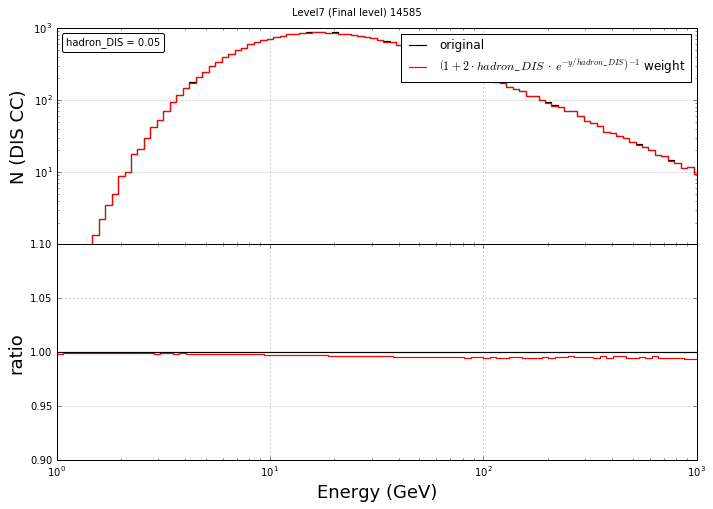

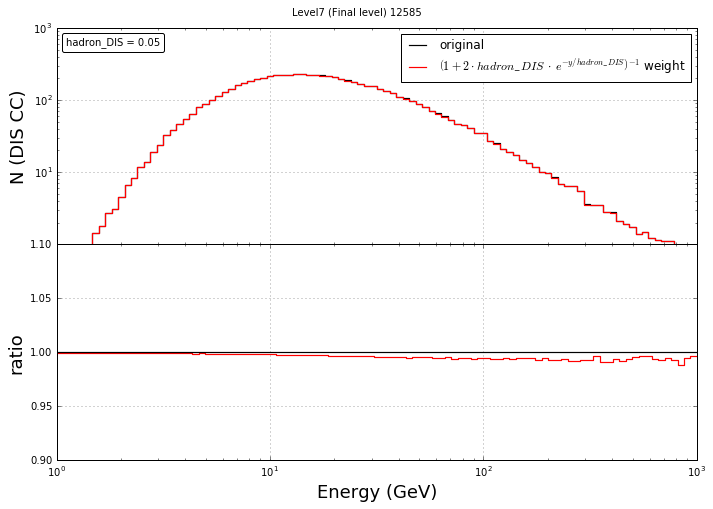

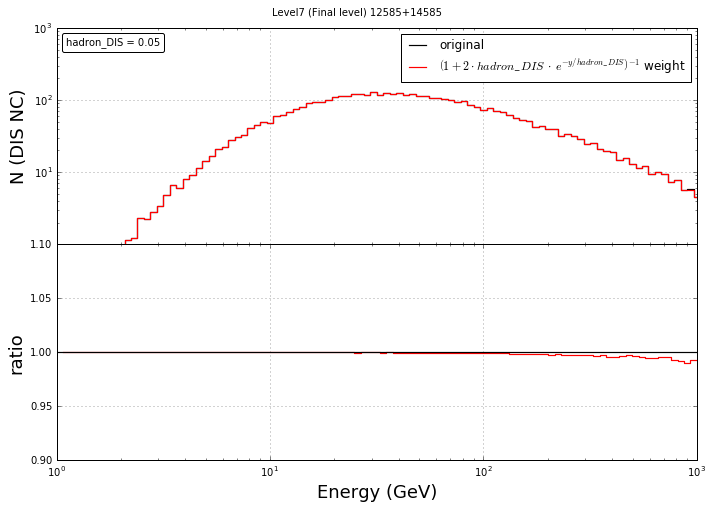

In [27]:
binning = np.logspace(0, 3, 100)

disnc_energy = []
disnc_weights = []
disnc_weights_raw = []
for name in DATA_DICT.iterkeys():
    discc = (DATA_DICT[name]['dis_array'] & DATA_DICT[name]['cc_array'])
    e_hist, edges = np.histogram(DATA_DICT[name]['energy_array'][discc], bins=binning,
                                 weights=DATA_DICT[name]['weights_raw'][discc])
    e_hist_w, edges = np.histogram(DATA_DICT[name]['energy_array'][discc], bins=binning,
                                   weights=DATA_DICT[name]['weights'][discc])

    make_plot(e_hist, e_hist_w, binning, name, 'N (DIS CC)', '{0}_energy_shift_discc_hadronization.png'.format(name))

    disnc = (DATA_DICT[name]['dis_array'] & ~DATA_DICT[name]['cc_array'])
    disnc_energy.append(DATA_DICT[name]['energy_array'][disnc])
    disnc_weights.append(DATA_DICT[name]['weights'][disnc])
    disnc_weights_raw.append(DATA_DICT[name]['weights_raw'][disnc])

disnc_energy, disnc_weights, disnc_weights_raw = map(np.hstack, (disnc_energy, disnc_weights, disnc_weights_raw))

e_hist, edges = np.histogram(disnc_energy, bins=binning, weights=disnc_weights_raw)
e_hist_w, edges = np.histogram(disnc_energy, bins=binning, weights=disnc_weights)

make_plot(e_hist, e_hist_w, binning, '12585+14585', 'N (DIS NC)', '12_14_energy_shift_hadronization.png')